In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('My Uber Drives - 2016.csv')
df.head(2)

START_DATE*       END_DATE* CATEGORY*       START*        STOP*  MILES*  \
0  1/1/2016 21:11  1/1/2016 21:17  Business  Fort Pierce  Fort Pierce     5.1   
1   1/2/2016 1:25   1/2/2016 1:37  Business  Fort Pierce  Fort Pierce     5.0   

         PURPOSE*  
0  Meal/Entertain  
1             NaN

In [3]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("*", '')
df.head(2)

START_DATE        END_DATE  CATEGORY        START         STOP  MILES  \
0  1/1/2016 21:11  1/1/2016 21:17  Business  Fort Pierce  Fort Pierce    5.1   
1   1/2/2016 1:25   1/2/2016 1:37  Business  Fort Pierce  Fort Pierce    5.0   

          PURPOSE  
0  Meal/Entertain  
1             NaN

In [4]:
df['START_DATE'] = pd.to_datetime(df['START_DATE'],errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'],errors='coerce')
df['hour'] = df['START_DATE'].dt.hour
df['day'] = df['START_DATE'].dt.day_name()
df['month'] = df['START_DATE'].dt.month_name()

In [5]:
time_diff = df['END_DATE'] - df['START_DATE']
time_diff

0      0 days 00:06:00
1      0 days 00:12:00
2      0 days 00:13:00
3      0 days 00:14:00
4      0 days 01:07:00
             ...      
1151   0 days 00:18:00
1152   0 days 00:35:00
1153   0 days 00:18:00
1154   0 days 01:43:00
1155               NaT
Length: 1156, dtype: timedelta64[ns]

In [6]:
time_diff.dt.total_seconds()/60

0         6.0
1        12.0
2        13.0
3        14.0
4        67.0
        ...  
1151     18.0
1152     35.0
1153     18.0
1154    103.0
1155      NaN
Length: 1156, dtype: float64

In [7]:
df['duration_min'] = time_diff.dt.total_seconds() / 60

In [8]:
df.head(2)

START_DATE            END_DATE  CATEGORY        START         STOP  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce  Fort Pierce   

   MILES         PURPOSE  hour       day    month  duration_min  
0    5.1  Meal/Entertain  21.0    Friday  January           6.0  
1    5.0             NaN   1.0  Saturday  January          12.0

# Analysis using Pandas

In [9]:
hourly = df.groupby('hour').agg(trips = ('duration_min','count'),
                               avg_dur = ('duration_min', 'mean'))
hourly.head(2)

trips    avg_dur
hour                  
0.0      19  13.894737
1.0       5  18.400000

In [10]:
#Number of Trips per hour of day
df_grouped = df.groupby("hour").size().reset_index(name='trips').sort_values('hour')
df_grouped.head(2)

hour  trips
0   0.0     19
1   1.0      5

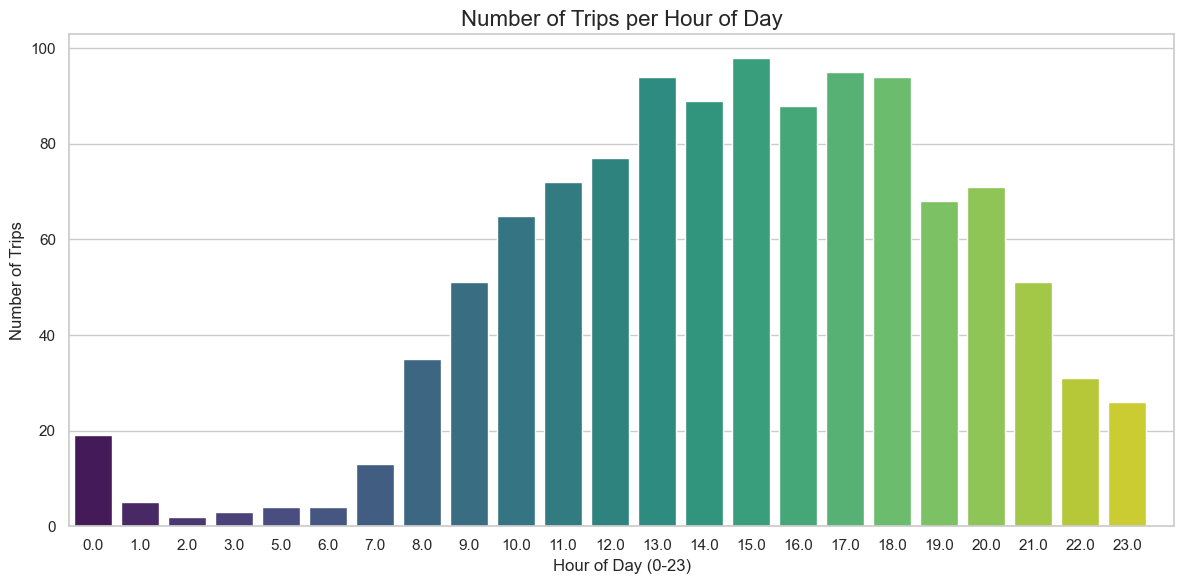

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='trips', data=df_grouped, palette='viridis')

plt.title('Number of Trips per Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()

In [12]:
#Average duration per hour
avgr = df.groupby('hour')['duration_min'].mean().reset_index(name='avg_dur').sort_values('hour')
avgr.head(2)

hour    avg_dur
0   0.0  13.894737
1   1.0  18.400000

([<matplotlib.axis.XTick at 0x3044cbb00>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

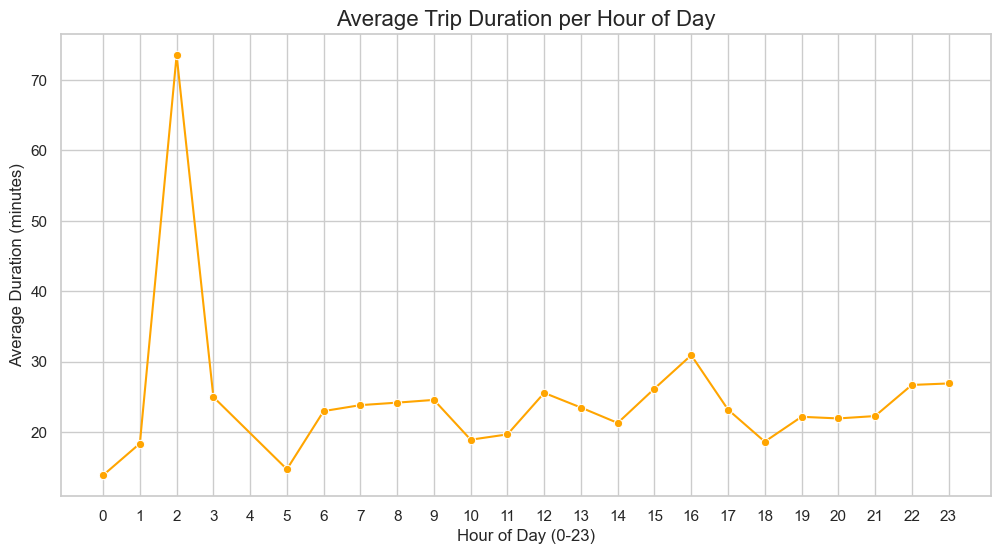

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='avg_dur', data=avgr, marker='o', color='orange')
plt.title('Average Trip Duration per Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Average Duration (minutes)', fontsize=12)
plt.xticks(range(0, 24))

In [14]:
#Trips by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

trips = df['day'].value_counts().reindex(day_order).reset_index()
trips.columns = ['Day', 'Trips']
trips.head(10)

Day  Trips
0     Monday    174
1    Tuesday    176
2  Wednesday    147
3   Thursday    154
4     Friday    206
5   Saturday    150
6     Sunday    148

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

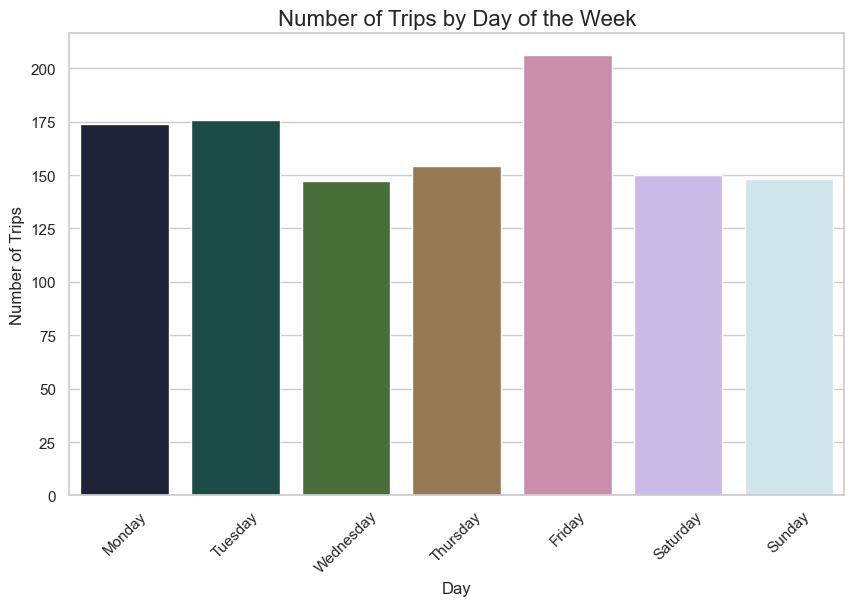

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='Trips', data=trips, palette='cubehelix')

plt.title('Number of Trips by Day of the Week', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(rotation=45)

In [ ]:
plt.figure(figsize=(14,6))
sns.heatmap(df.groupby(['day','hour']).size().unstack(fill_value=0),cmap="YlGnBu")
plt.show()

In [18]:
#Monthly trip counts
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
month_trip = df['month'].value_counts().reindex(month_order).reset_index()
month_trip.columns = ["Month", 'Trips']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

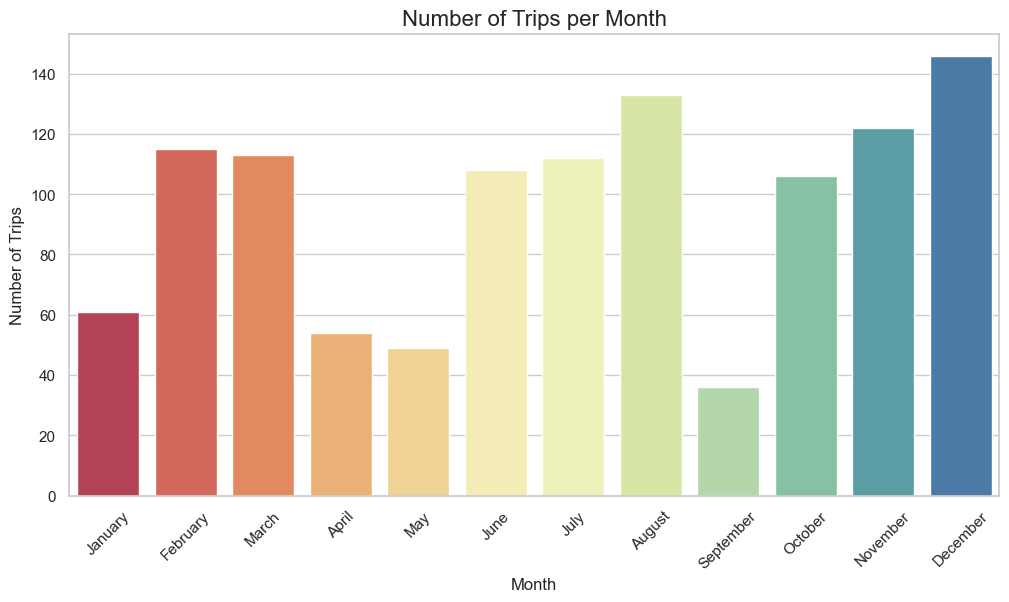

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Trips', data=month_trip, palette='Spectral')
plt.title('Number of Trips per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(rotation=45)

In [20]:
# Weekday vs weekend breakdown
df['day_type'] = df['day'].apply(lambda x:'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
result = df.groupby('day_type').size().reset_index(name='Count')

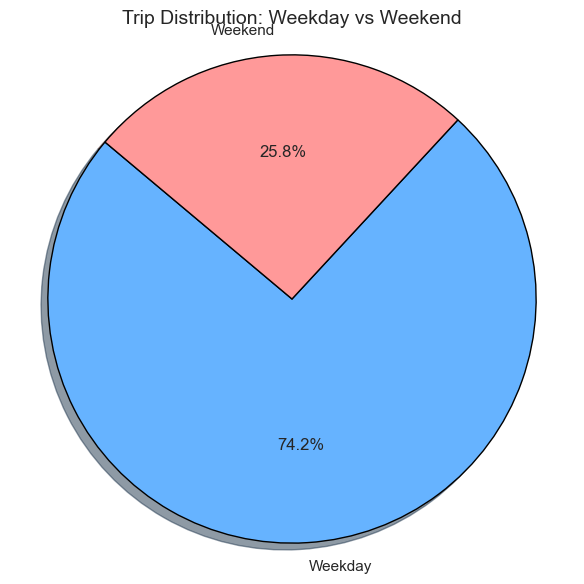

In [21]:
labels = result['day_type']
sizes = result['Count']
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(6, 6))
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=140,colors=colors,wedgeprops={'edgecolor': 'black'},shadow=True)

plt.title('Trip Distribution: Weekday vs Weekend', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [22]:
df.head(5)

START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE  hour        day    month  \
0      Fort Pierce    5.1   Meal/Entertain  21.0     Friday  January   
1      Fort Pierce    5.0              NaN   1.0   Saturday  January   
2      Fort Pierce    4.8  Errand/Supplies  20.0   Saturday  January   
3      Fort Pierce    4.7          Meeting  17.0    Tuesday  January   
4  West Palm Beach   63.7   Customer Visit  14.0  Wednesday  January   

   duration_min day_type  
0           6.0  Weekday  
1          12.0  Weekend  
2          13.0  Weekend  
3          14.0  Weekday  
4          67.0  Weekday

In [23]:
df['START'] = df['START'].replace('Kar?chi','Karachi')
df['STOP'] = df['STOP'].replace('Kar?chi','Karachi')

In [25]:
# Top Pickup Zones
top_pickup_zones = (
    df['START'].value_counts().head(10).reset_index()
)

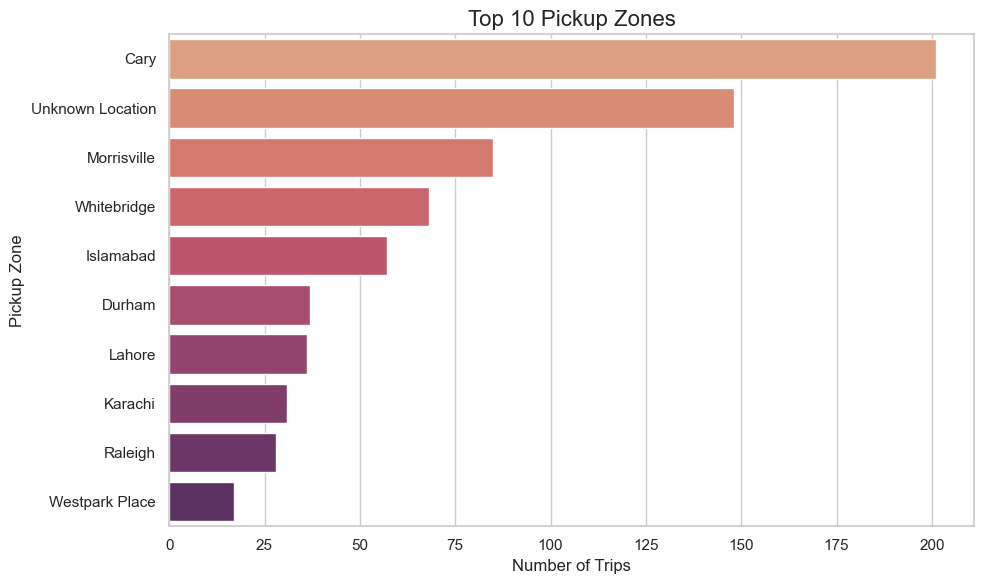

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(y='START', x='count', data=top_pickup_zones, palette='flare')

plt.title('Top 10 Pickup Zones', fontsize=16)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Pickup Zone', fontsize=12)

plt.tight_layout()
plt.show()

In [27]:
# Top DropOff Zones
top_dropOff_zones = (
    df['STOP'].value_counts().head(10).reset_index()
)

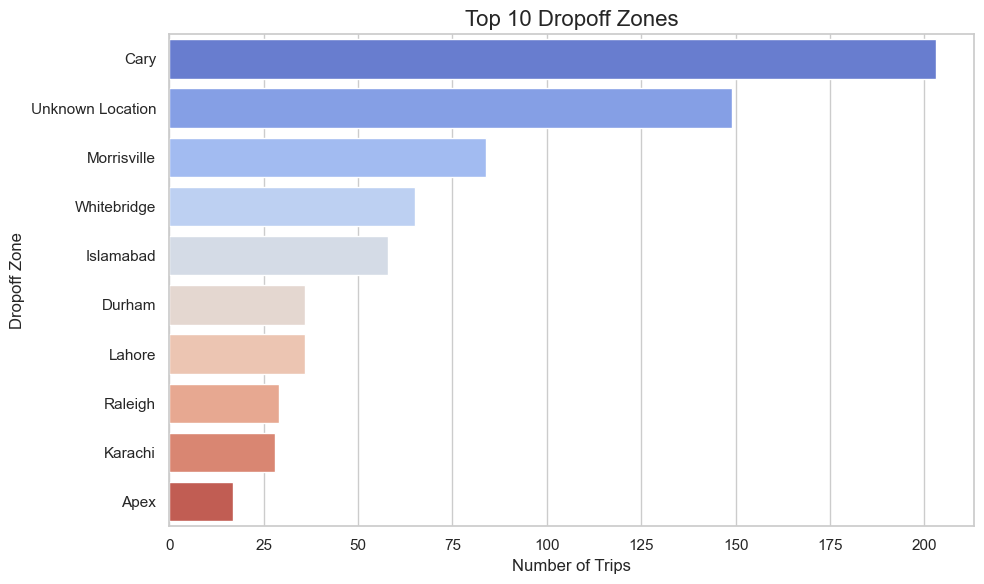

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(y='STOP', x='count', data=top_dropOff_zones, palette='coolwarm')

plt.title('Top 10 Dropoff Zones', fontsize=16)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Dropoff Zone', fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
# Lahore trips by day
airport_trips = (
    df[(df['START'] == 'Lahore') | (df['STOP'] == 'Lahore')].groupby('day').size().reset_index(name='Lahore Trips')
)

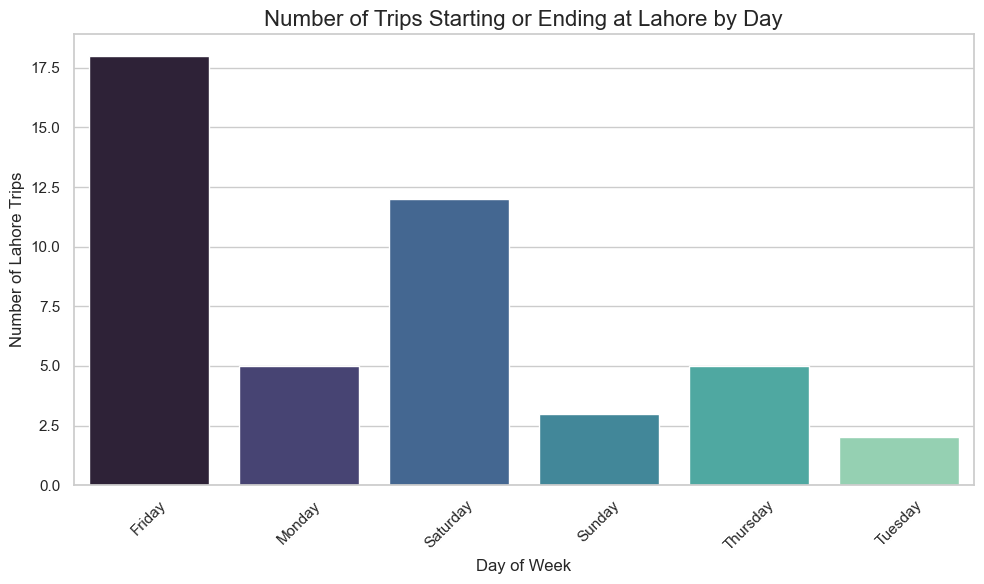

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(x='day', y='Lahore Trips', data=airport_trips, palette='mako')

plt.title('Number of Trips Starting or Ending at Lahore by Day', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Lahore Trips', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [31]:
# Distribution of trip distances

bins = [0, 1, 5, 10, float('inf')]
labels = ['<1km', '1–5', '5–10', '10+']

df['dist_range'] = pd.cut(df['MILES'], bins=bins, labels=labels,right=False)
result = df.groupby('dist_range').size().reset_index(name='trips')

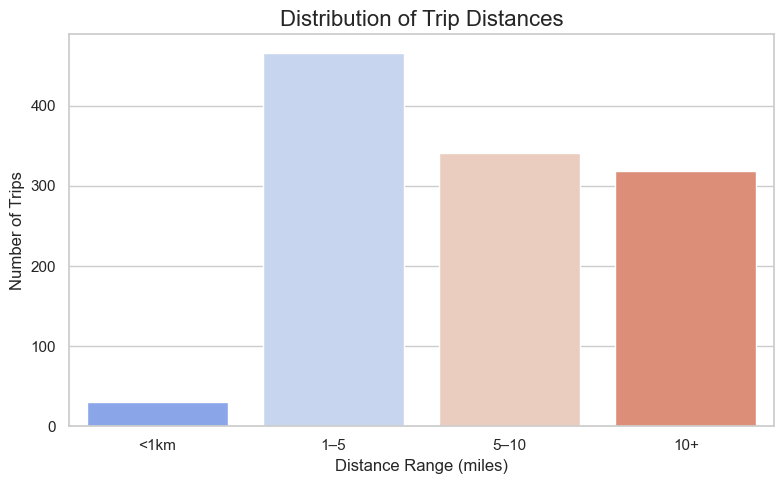

In [32]:
plt.figure(figsize=(8,5))
sns.barplot(x='dist_range', y='trips', data=result, palette='coolwarm')

plt.title('Distribution of Trip Distances', fontsize=16)
plt.xlabel('Distance Range (miles)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
df.head(5)

START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE  hour        day    month  \
0      Fort Pierce    5.1   Meal/Entertain  21.0     Friday  January   
1      Fort Pierce    5.0              NaN   1.0   Saturday  January   
2      Fort Pierce    4.8  Errand/Supplies  20.0   Saturday  January   
3      Fort Pierce    4.7          Meeting  17.0    Tuesday  January   
4  West Palm Beach   63.7   Customer Visit  14.0  Wednesday  January   

   duration_min day_type dist_range  
0           6.0  Weekday       5–10  
1          12.0  Weekend       5–10  
2          13.0  Weekend        1–5  
3          14.0  Weekday        1–5  
4          67.0  Weekday        10+

In [34]:
#Short vs Long Distance
print(f'The Minumum Duration Min is : {df['duration_min'].min()}')
print(f'The Maximum Duration Min is : {df['duration_min'].max()}')

The Minumum Duration Min is : 0.0
The Maximum Duration Min is : 336.0


In [35]:
#Longest trip each day
df['trip_day'] = df['START_DATE'].dt.date
result = df.groupby('trip_day')['duration_min'].max().reset_index(name='max_duration')

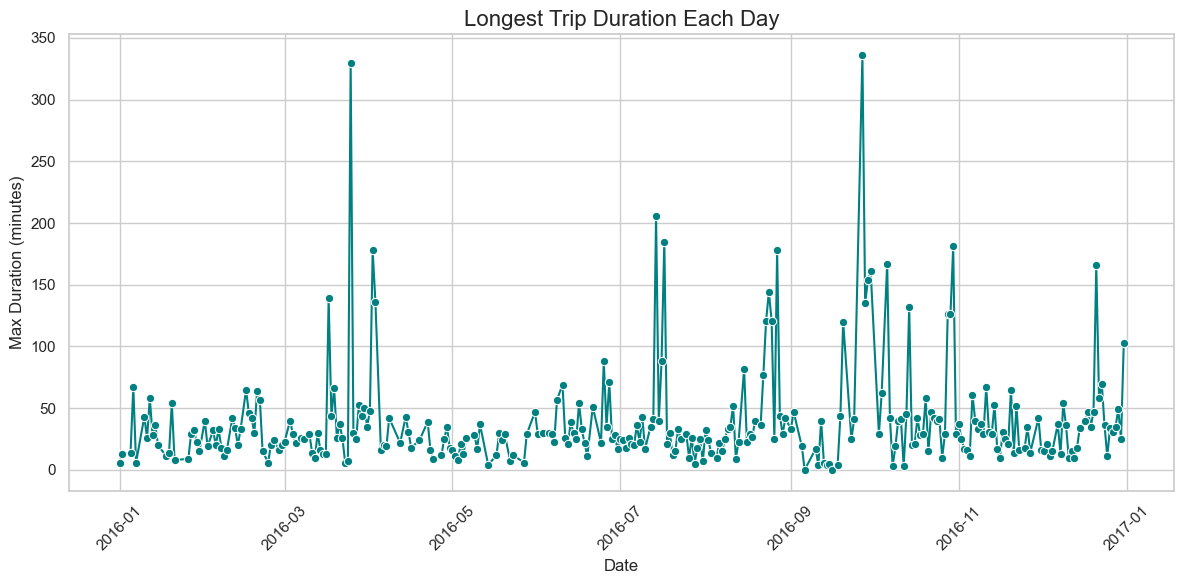

In [36]:
plt.figure(figsize=(12,6))
sns.lineplot(x='trip_day', y='max_duration', data=result, marker='o', color='teal')

plt.title('Longest Trip Duration Each Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Max Duration (minutes)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [37]:
# Trip distribution by hour bucket
conditions = [
    df['hour'].between(0,5),
    df['hour'].between(6,11),
    df['hour'].between(12,17),
    df['hour'].between(18,23),
]
choices =  ['Late Night', 'Morning', 'Afternoon', 'Evening']
df['time_bucket'] = np.select(conditions, choices, default='Unknown')
result = df.groupby('time_bucket').size().reset_index(name='trip_count')

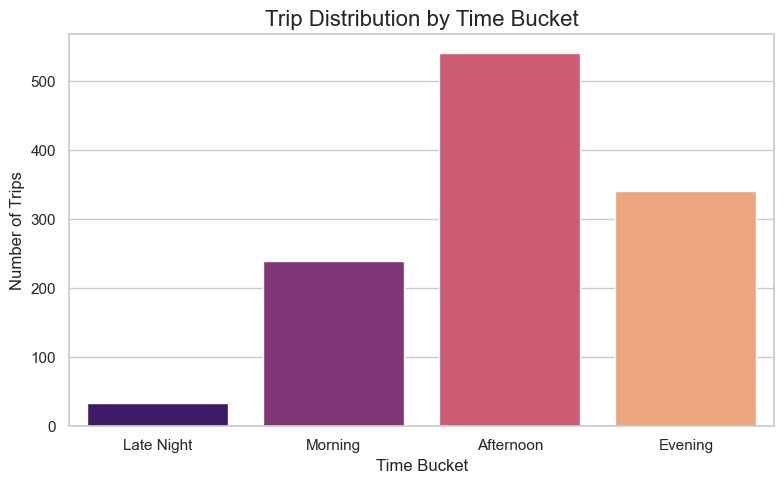

In [39]:
plt.figure(figsize=(8,5))
sns.barplot(x='time_bucket', y='trip_count', data=result, order=choices, palette='magma')

plt.title('Trip Distribution by Time Bucket', fontsize=16)
plt.xlabel('Time Bucket', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)

plt.tight_layout()
plt.show()

In [40]:
#Average duration per day-of-week
avg_duration_day = df.groupby('day')['duration_min'].mean().reset_index()

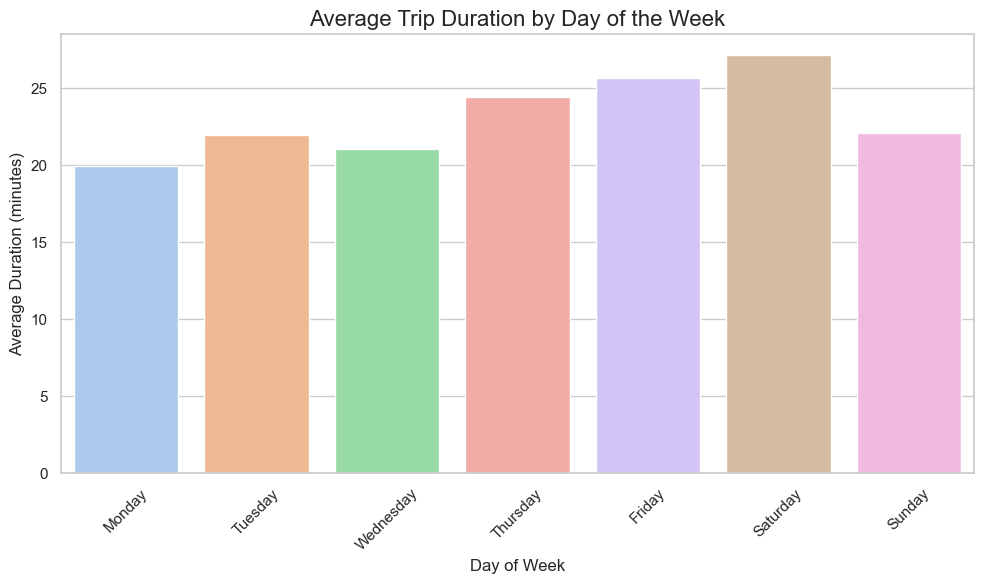

In [41]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10,6))
sns.barplot(x='day', y='duration_min', data=avg_duration_day, order=day_order, palette='pastel')

plt.title('Average Trip Duration by Day of the Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Duration (minutes)', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
#Most common pickup–dropoff pairs
top_pairs = df.groupby(['START', 'STOP']).size().reset_index(name='trips').sort_values('trips', ascending=False).head(10)

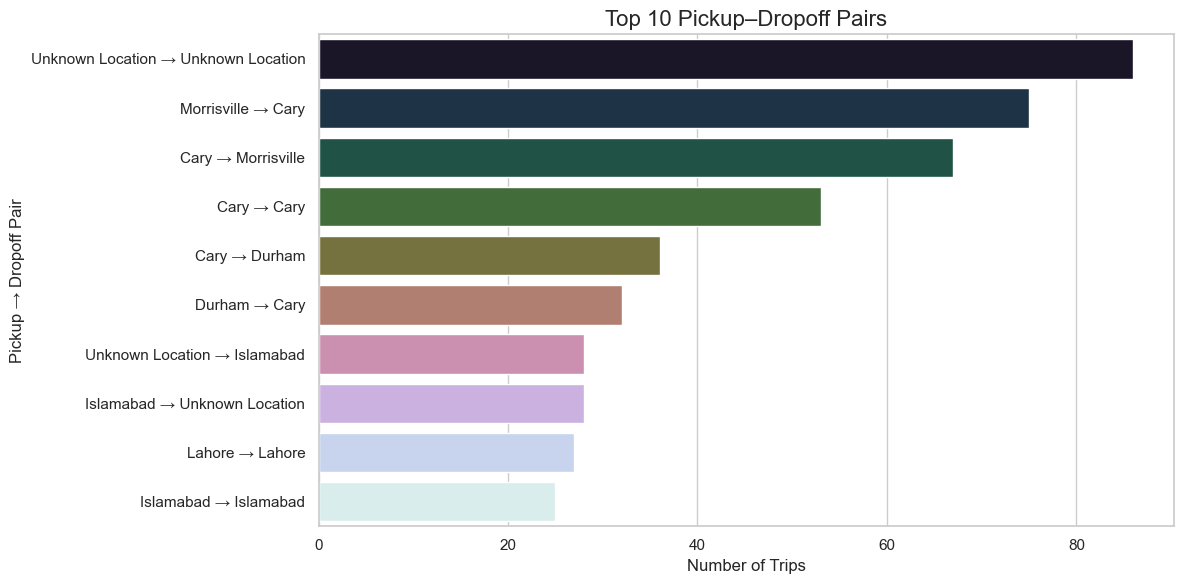

In [43]:
top_pairs['pair'] = top_pairs['START'] + ' → ' + top_pairs['STOP']
sns.set(style="whitegrid")

plt.figure(figsize=(12,6))
sns.barplot(y='pair', x='trips', data=top_pairs, palette='cubehelix')
plt.title('Top 10 Pickup–Dropoff Pairs', fontsize=16)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Pickup → Dropoff Pair', fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
#Trips within same zone (short trips)
df[df['START'] == df['STOP']].shape[0]

288

In [45]:
df.describe(include='all')

START_DATE                       END_DATE  \
count                            1155                           1155   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean    2016-07-16 23:44:33.402597376  2016-07-17 00:07:47.999999744   
min               2016-01-01 21:11:00            2016-01-01 21:17:00   
25%               2016-04-01 02:10:00            2016-04-01 02:35:00   
50%               2016-07-21 17:17:00            2016-07-21 17:23:00   
75%               2016-10-27 21:06:30            2016-10-27 21:21:00   
max               2016-12-31 22:08:00            2016-12-31 23:51:00   
std                               NaN                            NaN   

        CATEGORY START  STOP         MILES  PURPOSE         hour     day  \
count       1155  1155  1155   1156.000000      653  1155.000000    1155   
unique         2   176   187           NaN       10          NaN       7   
top     Business  Cary  Cary           NaN  Meeting          NaN  Friday   
freq        1078   201   203           NaN      187          NaN     206   
mean         NaN   NaN   NaN     21.115398      NaN    14.696104     NaN   
min          NaN   NaN   NaN      0.500000      NaN     0.000000     NaN   
25%          NaN   NaN   NaN      2.900000      NaN    12.000000     NaN   
50%          NaN   NaN   NaN      6.000000      NaN    15.000000     NaN   
75%          NaN   NaN   NaN     10.400000      NaN    18.000000     NaN   
max          NaN   NaN   NaN  12204.700000      NaN    23.000000     NaN   
std          NaN   NaN   NaN    359.299007      NaN     4.575226     NaN   

           month  duration_min day_type dist_range    trip_day time_bucket  
count       1155   1155.000000     1156       1156        1155        1156  
unique        12           NaN        2          4         294           5  
top     December           NaN  Weekday        1–5  2016-12-29   Afternoon  
freq         146           NaN      858        466          13         541  
mean         NaN     23.243290      NaN        NaN         NaN         NaN  
min          NaN      0.000000      NaN        NaN         NaN         NaN  
25%          NaN     10.000000      NaN        NaN         NaN         NaN  
50%          NaN     16.000000      NaN        NaN         NaN         NaN  
75%          NaN     27.500000      NaN        NaN         NaN         NaN  
max          NaN    336.000000      NaN        NaN         NaN         NaN  
std          NaN     27.318277      NaN        NaN         NaN         NaN

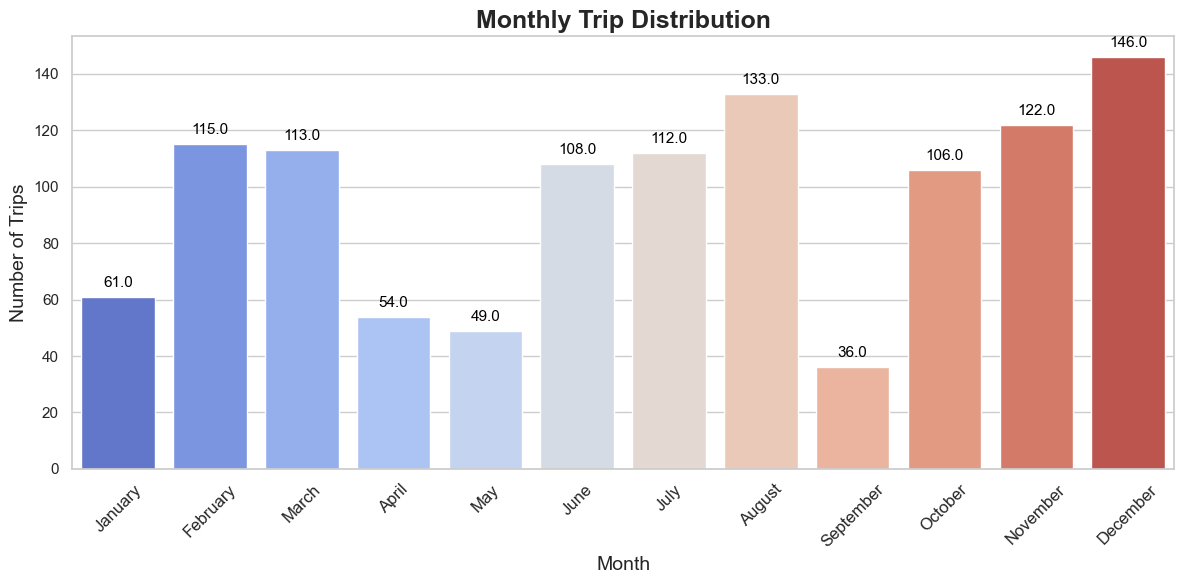

In [47]:
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=df, order=month_order, palette='coolwarm')
plt.title("Monthly Trip Distribution", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.xticks(rotation=45, fontsize=12)

ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

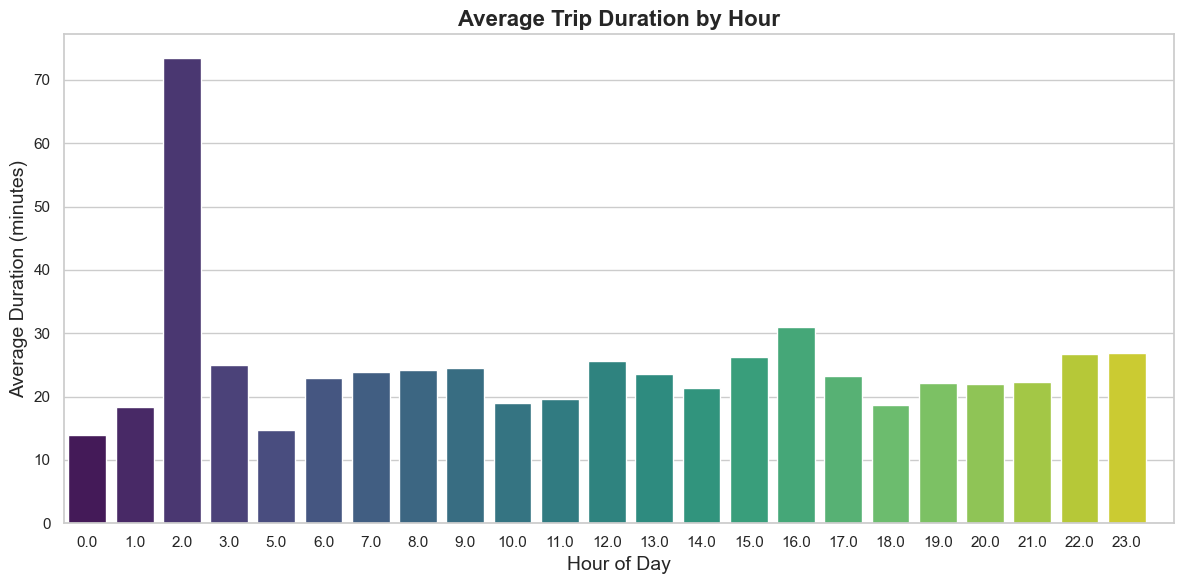

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(x='hour',y='duration_min',data=df,estimator='mean',ci=None,palette='viridis')
plt.title("Average Trip Duration by Hour", fontsize=16, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Average Duration (minutes)", fontsize=14)
plt.xticks(range(0, 24))  

plt.tight_layout()
plt.show()

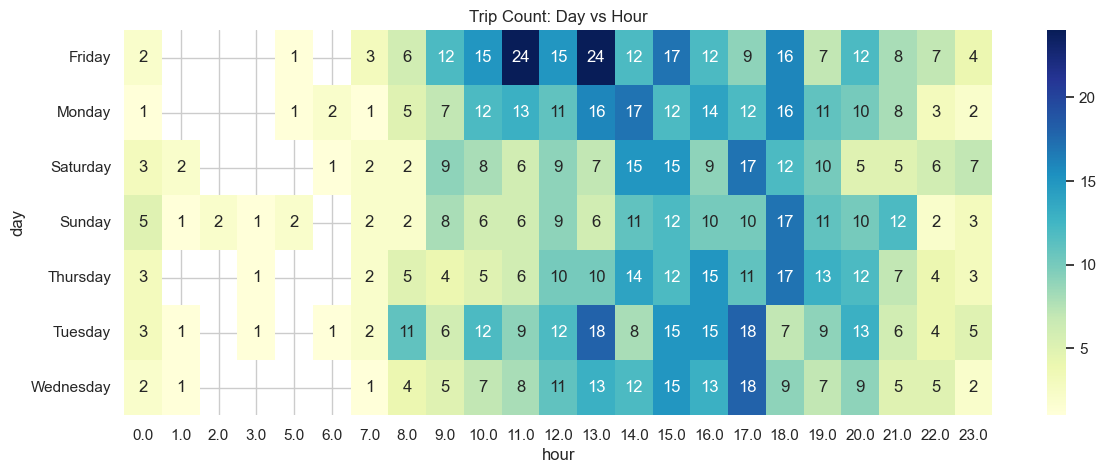

In [49]:
#Heatmap: Day vs Hour
plt.figure(figsize=(14,5))
pivot = df.pivot_table(index='day', columns='hour', values='duration_min', aggfunc='count')
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt='g')
plt.title("Trip Count: Day vs Hour")
plt.show()

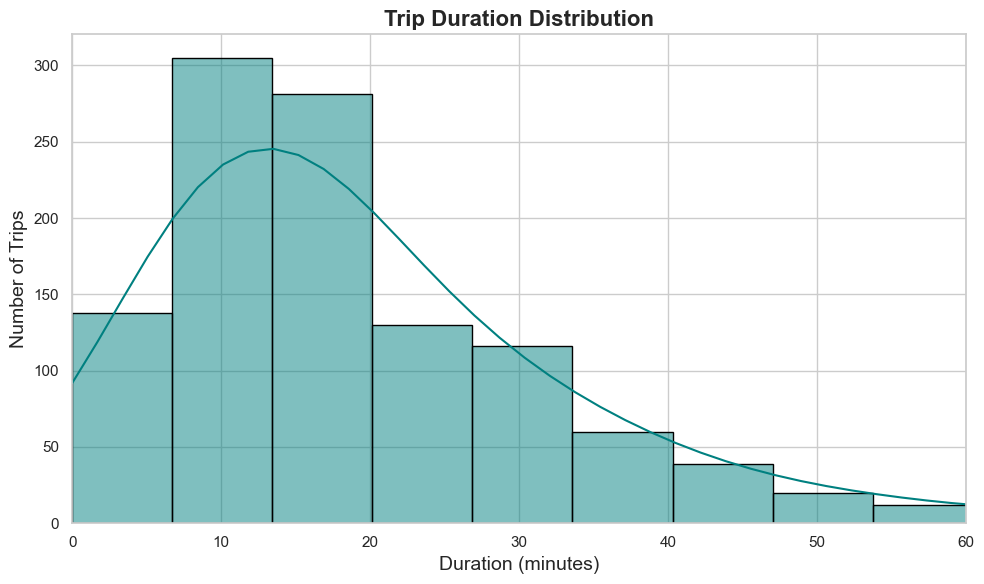

In [50]:
#Distribution of Trip Duration
plt.figure(figsize=(10,6))
sns.histplot(df['duration_min'],bins=50,kde=True,color='teal',edgecolor='black')

plt.title("Trip Duration Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Duration (minutes)", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.xlim(0, 60)

plt.tight_layout()
plt.show()

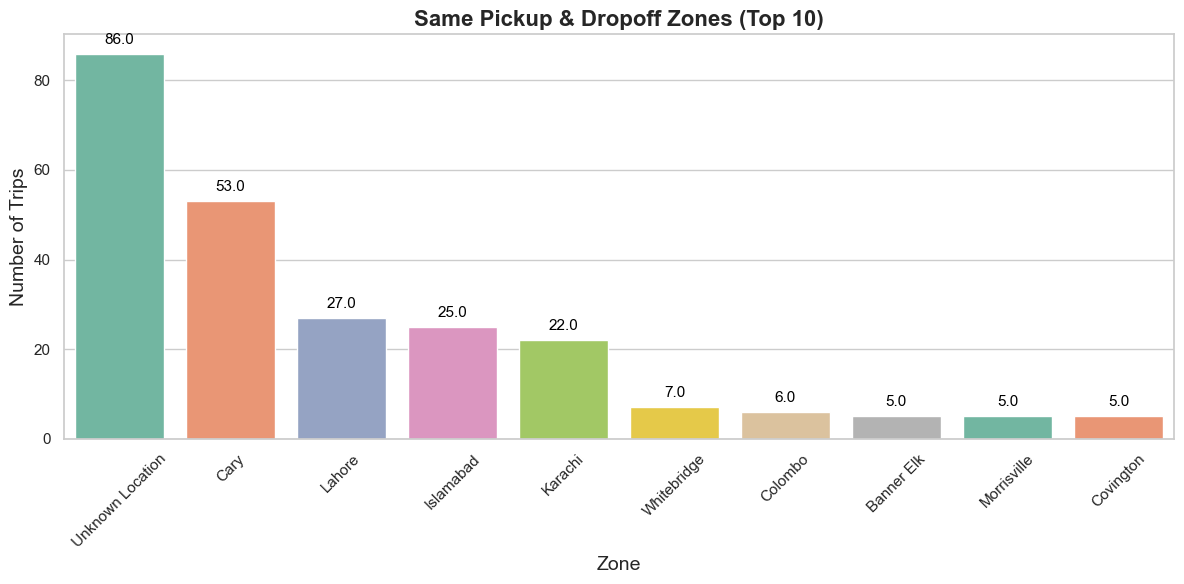

In [51]:
same_zone = df[df['START'] == df['STOP']]
top_zones = same_zone['START'].value_counts().head(10).index

plt.figure(figsize=(12,6))
ax = sns.countplot(x='START', data=same_zone, order=top_zones, palette='Set2')

plt.title("Same Pickup & Dropoff Zones (Top 10)", fontsize=16, fontweight='bold')
plt.xlabel("Zone", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

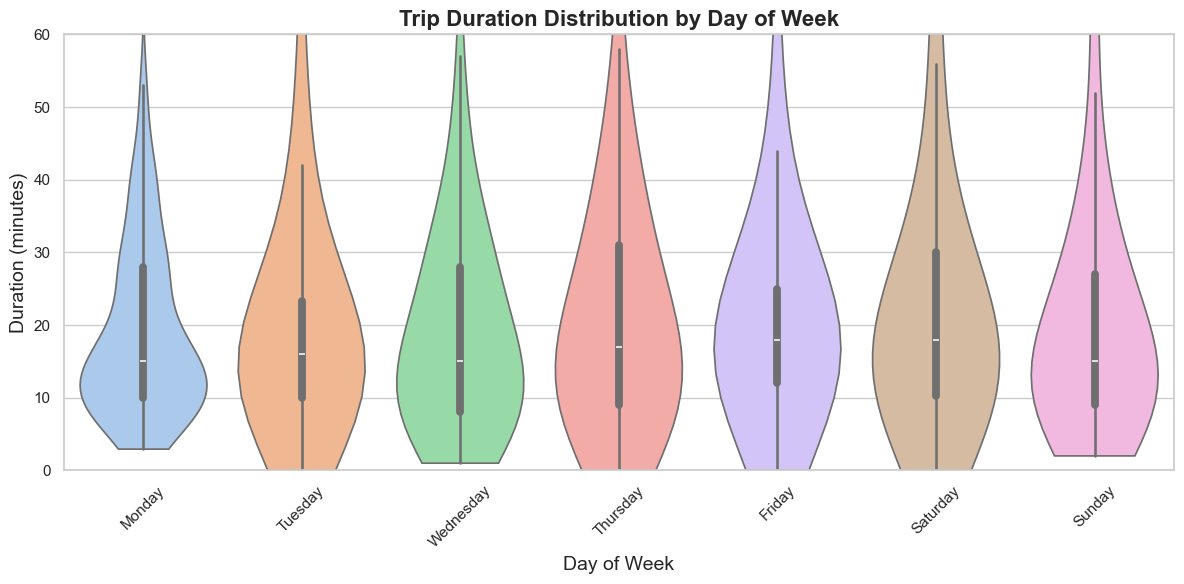

In [52]:
#Duration by Day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12,6))

sns.violinplot(x='day', y='duration_min', data=df,order=day_order,palette='pastel',cut=0  )

plt.title("Trip Duration Distribution by Day of Week", fontsize=16, fontweight='bold')
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Duration (minutes)", fontsize=14)
plt.ylim(0, 60)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [53]:
df.head(3)

START_DATE            END_DATE  CATEGORY        START         STOP  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce  Fort Pierce   

   MILES          PURPOSE  hour       day    month  duration_min day_type  \
0    5.1   Meal/Entertain  21.0    Friday  January           6.0  Weekday   
1    5.0              NaN   1.0  Saturday  January          12.0  Weekend   
2    4.8  Errand/Supplies  20.0  Saturday  January          13.0  Weekend   

  dist_range    trip_day time_bucket  
0       5–10  2016-01-01     Evening  
1       5–10  2016-01-02  Late Night  
2        1–5  2016-01-02     Evening

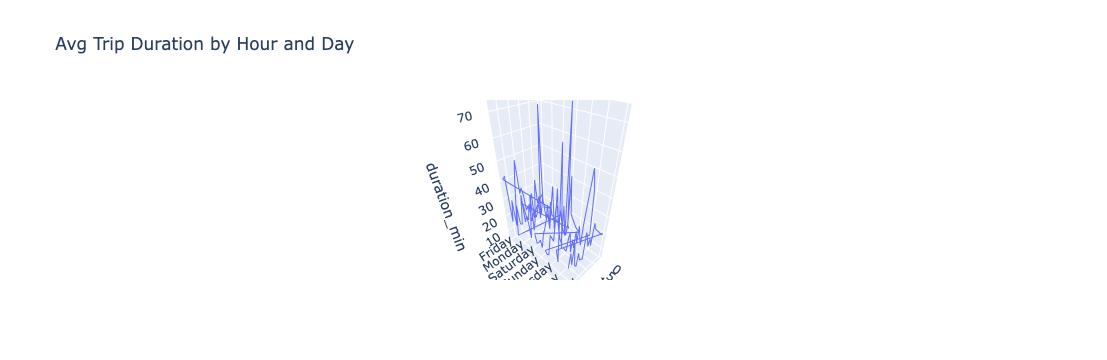

In [54]:
avg_duration = df.groupby(['day', 'hour'])['duration_min'].mean().reset_index()

fig = px.line_3d(avg_duration, x='hour', y='day', z='duration_min', 
                 title='Avg Trip Duration by Hour and Day')
fig.show()

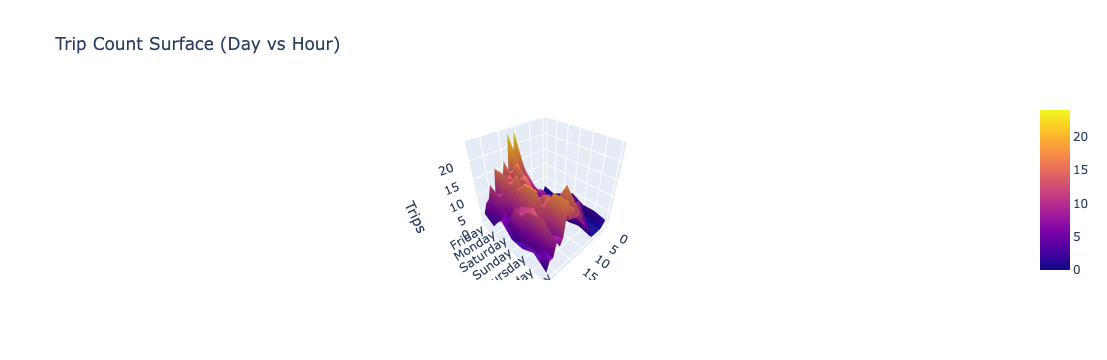

In [55]:
import plotly.graph_objects as go
pivot = df.groupby(['day', 'hour']).size().unstack().fillna(0)
days = list(pivot.index)
hours = list(pivot.columns)
z = pivot.values

fig = go.Figure(data=[go.Surface(z=z, x=hours, y=days)])
fig.update_layout(title='Trip Count Surface (Day vs Hour)',
                  scene=dict(xaxis_title='Hour', yaxis_title='Day', zaxis_title='Trips'))
fig.show()

In [56]:
df.head(5)

START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE  hour        day    month  \
0      Fort Pierce    5.1   Meal/Entertain  21.0     Friday  January   
1      Fort Pierce    5.0              NaN   1.0   Saturday  January   
2      Fort Pierce    4.8  Errand/Supplies  20.0   Saturday  January   
3      Fort Pierce    4.7          Meeting  17.0    Tuesday  January   
4  West Palm Beach   63.7   Customer Visit  14.0  Wednesday  January   

   duration_min day_type dist_range    trip_day time_bucket  
0           6.0  Weekday       5–10  2016-01-01     Evening  
1          12.0  Weekend       5–10  2016-01-02  Late Night  
2          13.0  Weekend        1–5  2016-01-02     Evening  
3          14.0  Weekday        1–5  2016-01-05   Afternoon  
4          67.0  Weekday        10+  2016-01-06   Afternoon

In [57]:
category_counts = df['CATEGORY'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

total_trips = category_counts['Count'].sum()
category_counts['Percentage'] = (category_counts['Count'] / total_trips) * 100
category_counts

Category  Count  Percentage
0  Business   1078   93.333333
1  Personal     77    6.666667

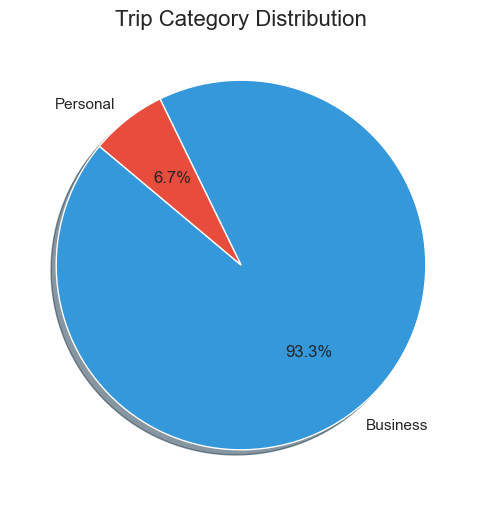

In [58]:
plt.figure(figsize=(6,6))
plt.pie(category_counts['Count'], labels=category_counts['Category'], autopct='%1.1f%%', colors=['#3498db', '#e74c3c'],
        startangle=140,shadow=True)
plt.title('Trip Category Distribution', fontsize=16)
plt.show()

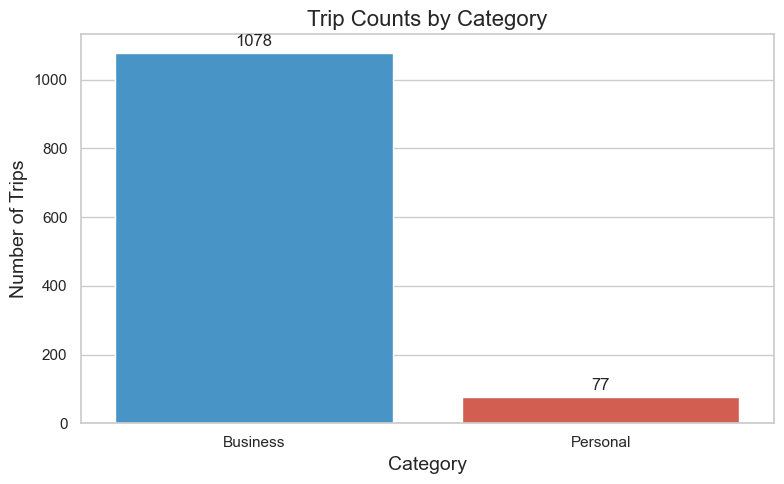

In [59]:
plt.figure(figsize=(8,5))
sns.barplot(x='Category', y='Count', data=category_counts, palette=['#3498db', '#e74c3c'])
plt.title('Trip Counts by Category', fontsize=16)
plt.ylabel('Number of Trips', fontsize=14)
plt.xlabel('Category', fontsize=14)

for index, row in category_counts.iterrows():
    plt.text(index, row['Count'] + 20, f"{row['Count']}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

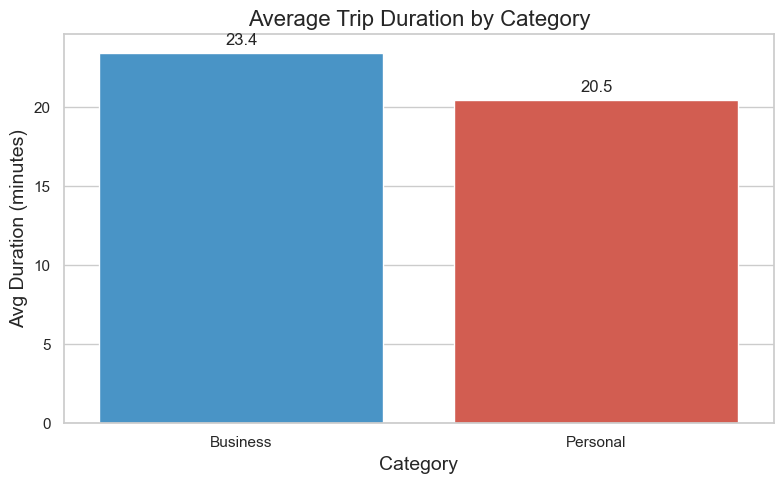

In [60]:
avg_duration = df.groupby('CATEGORY')['duration_min'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='CATEGORY', y='duration_min', data=avg_duration, palette=['#3498db', '#e74c3c'])
plt.title('Average Trip Duration by Category', fontsize=16)
plt.ylabel('Avg Duration (minutes)', fontsize=14)
plt.xlabel('Category', fontsize=14)

for index, row in avg_duration.iterrows():
    plt.text(index, row['duration_min'] + 0.5, f"{row['duration_min']:.1f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

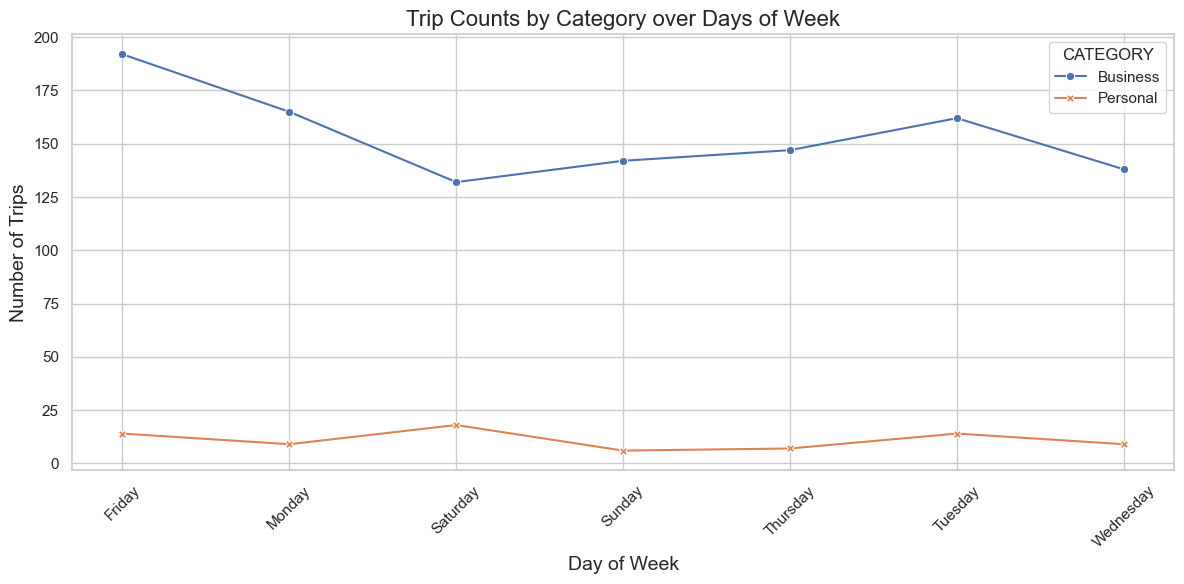

In [61]:
# Count trips by category and day
cat_day = df.groupby(['CATEGORY', 'day']).size().reset_index(name='trip_count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12,6))
sns.lineplot(data=cat_day, x='day', y='trip_count', hue='CATEGORY', style='CATEGORY',
             markers=True, dashes=False, hue_order=['Business', 'Personal'], sort=False)

plt.title('Trip Counts by Category over Days of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

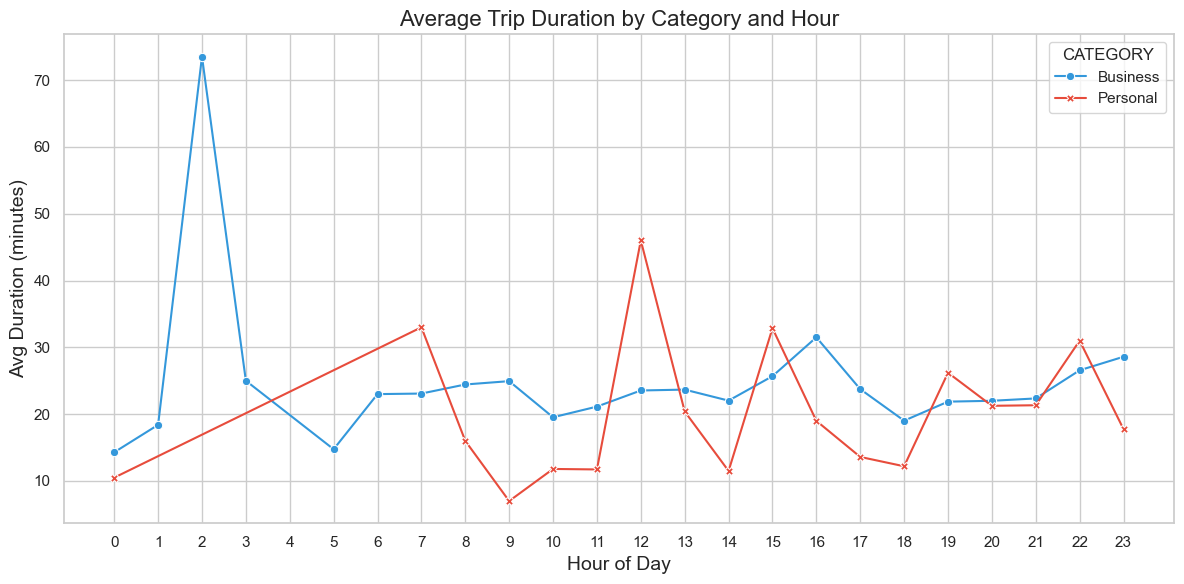

In [62]:
avg_duration_hour = df.groupby(['CATEGORY', 'hour'])['duration_min'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=avg_duration_hour, x='hour', y='duration_min', hue='CATEGORY', style='CATEGORY',
             markers=True, dashes=False, palette=['#3498db', '#e74c3c'])

plt.title('Average Trip Duration by Category and Hour', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Avg Duration (minutes)', fontsize=14)
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

In [63]:
from scipy.stats import ttest_ind

business_dur = df[df['CATEGORY'] == 'Business']['duration_min'].dropna()
personal_dur = df[df['CATEGORY'] == 'Personal']['duration_min'].dropna()

t_stat, p_value = ttest_ind(business_dur, personal_dur, equal_var=False)

print(f"T-test results:\n t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("=> Significant difference in average trip durations between Business and Personal")
else:
    print("=> No significant difference in average trip durations between Business and Personal")

T-test results:
 t-statistic = 1.039, p-value = 0.3018
=> No significant difference in average trip durations between Business and Personal


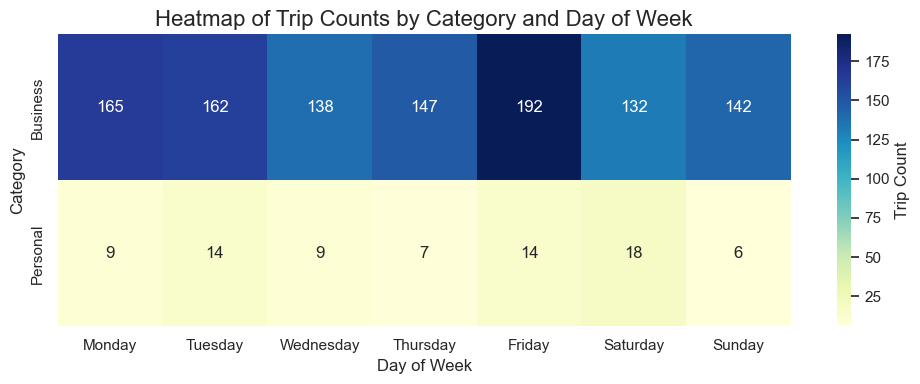

In [64]:
# Pivot data for heatmap: counts of trips by category and day
cat_day_counts = df.groupby(['CATEGORY', 'day']).size().reset_index(name='trip_count')

cat_day_counts['day'] = pd.Categorical(cat_day_counts['day'], categories=day_order, ordered=True)
heatmap_data = cat_day_counts.pivot(index='CATEGORY', columns='day', values='trip_count')

plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Trip Count'})
plt.title('Heatmap of Trip Counts by Category and Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

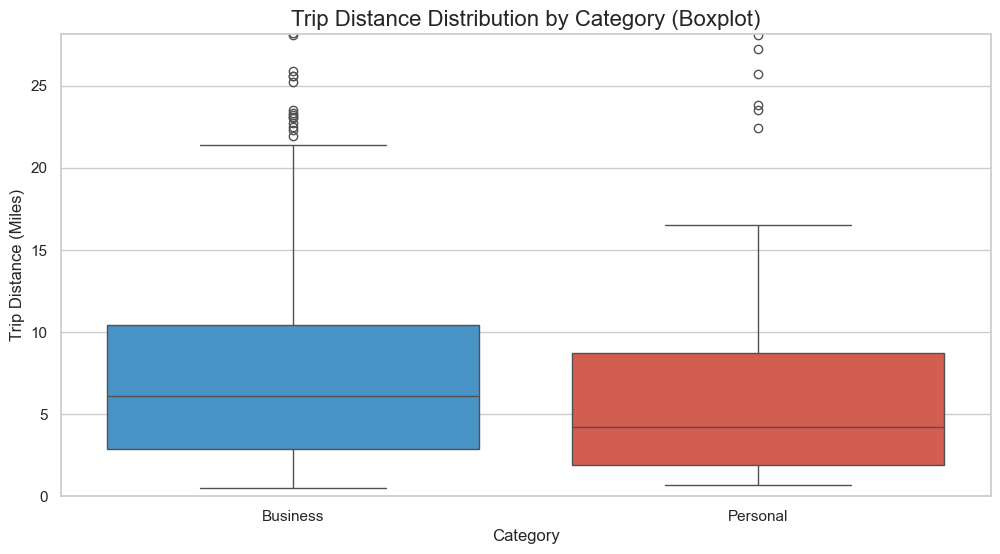

In [65]:
plt.figure(figsize=(12,6))

sns.boxplot(x='CATEGORY', y='MILES', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Trip Distance Distribution by Category (Boxplot)', fontsize=16)
plt.ylabel('Trip Distance (Miles)')
plt.xlabel('Category')
plt.ylim(0, df['MILES'].quantile(0.95))
plt.show()

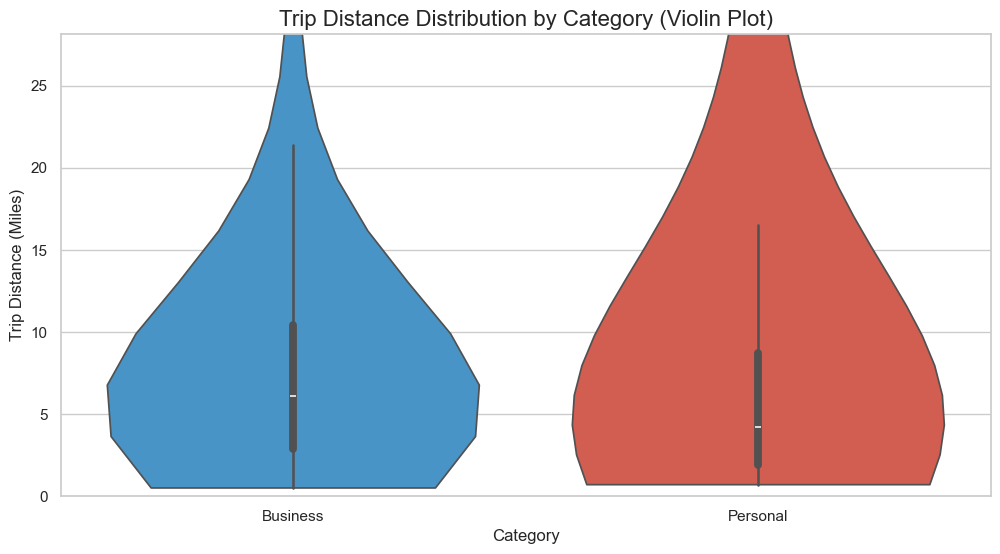

In [66]:
plt.figure(figsize=(12,6))
sns.violinplot(x='CATEGORY', y='MILES', data=df, palette=['#3498db', '#e74c3c'], cut=0)
plt.title('Trip Distance Distribution by Category (Violin Plot)', fontsize=16)
plt.ylabel('Trip Distance (Miles)')
plt.xlabel('Category')
plt.ylim(0, df['MILES'].quantile(0.95))

plt.show()

In [67]:
df.head(5)

START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE  hour        day    month  \
0      Fort Pierce    5.1   Meal/Entertain  21.0     Friday  January   
1      Fort Pierce    5.0              NaN   1.0   Saturday  January   
2      Fort Pierce    4.8  Errand/Supplies  20.0   Saturday  January   
3      Fort Pierce    4.7          Meeting  17.0    Tuesday  January   
4  West Palm Beach   63.7   Customer Visit  14.0  Wednesday  January   

   duration_min day_type dist_range    trip_day time_bucket  
0           6.0  Weekday       5–10  2016-01-01     Evening  
1          12.0  Weekend       5–10  2016-01-02  Late Night  
2          13.0  Weekend        1–5  2016-01-02     Evening  
3          14.0  Weekday        1–5  2016-01-05   Afternoon  
4          67.0  Weekday        10+  2016-01-06   Afternoon

In [68]:
df['MILES'].describe()

count     1156.000000
mean        21.115398
std        359.299007
min          0.500000
25%          2.900000
50%          6.000000
75%         10.400000
max      12204.700000
Name: MILES, dtype: float64

In [70]:
outliers = df[df['MILES'] > 100]
print(f"Number of trips with distance > 200 miles: {len(outliers)}")
outliers[['MILES']].head()

Number of trips with distance > 200 miles: 17


MILES
232  136.0
268  144.0
269  310.3
270  201.0
297  174.2

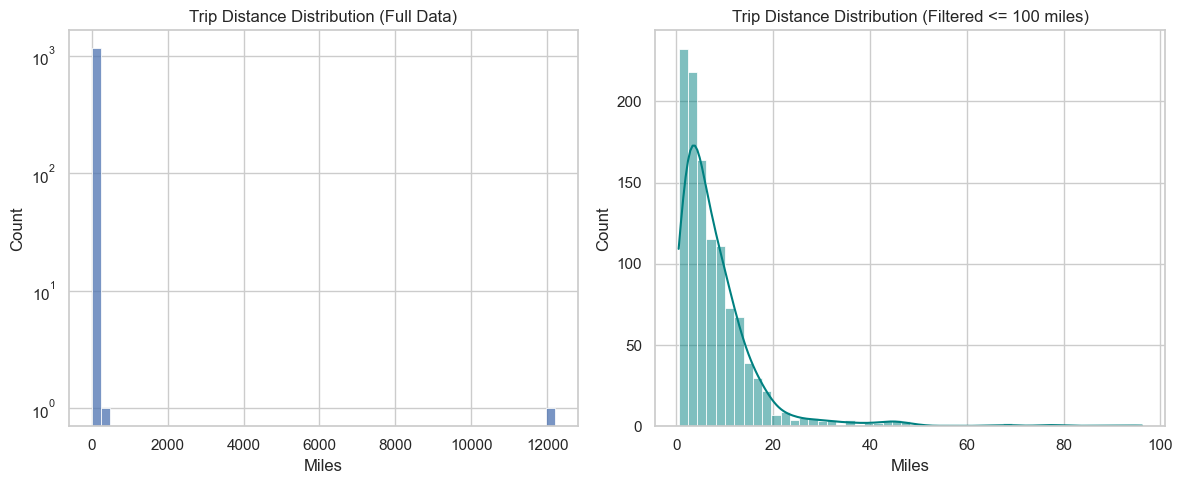

In [72]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(df['MILES'], bins=50, kde=False)
plt.title('Trip Distance Distribution (Full Data)')
plt.xlabel('Miles')
plt.ylabel('Count')
plt.yscale('log')

# Filter out outliers > 100 miles
df_filtered = df[df['MILES'] <= 100]

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['MILES'], bins=50, kde=True, color='teal')
plt.title('Trip Distance Distribution (Filtered <= 100 miles)')
plt.xlabel('Miles')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [73]:
df_clean = df[df['MILES'] <= 100].copy()

In [74]:
df_clean['MILES'].describe()

count    1139.000000
mean        8.389640
std         9.801798
min         0.500000
25%         2.800000
50%         5.900000
75%        10.400000
max        96.200000
Name: MILES, dtype: float64

In [75]:
median_miles = df.loc[df['MILES'] <= 100, 'MILES'].median()

df['MILES_cleaned'] = df['MILES'].apply(lambda x: median_miles if x > 100 else x)

print(f"Median miles (for trips <= 100 miles): {median_miles:.2f}")
df[['MILES', 'MILES_cleaned']].head(10)

Median miles (for trips <= 100 miles): 5.90


MILES  MILES_cleaned
0    5.1            5.1
1    5.0            5.0
2    4.8            4.8
3    4.7            4.7
4   63.7           63.7
5    4.3            4.3
6    7.1            7.1
7    0.8            0.8
8    8.3            8.3
9   16.5           16.5

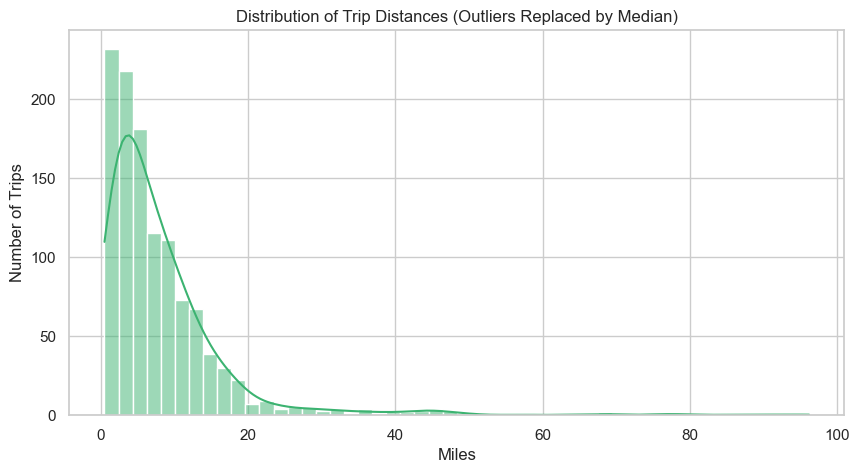

In [76]:
plt.figure(figsize=(10,5))
sns.histplot(df['MILES_cleaned'], bins=50, kde=True, color='mediumseagreen')
plt.title('Distribution of Trip Distances (Outliers Replaced by Median)')
plt.xlabel('Miles')
plt.ylabel('Number of Trips')
plt.show()

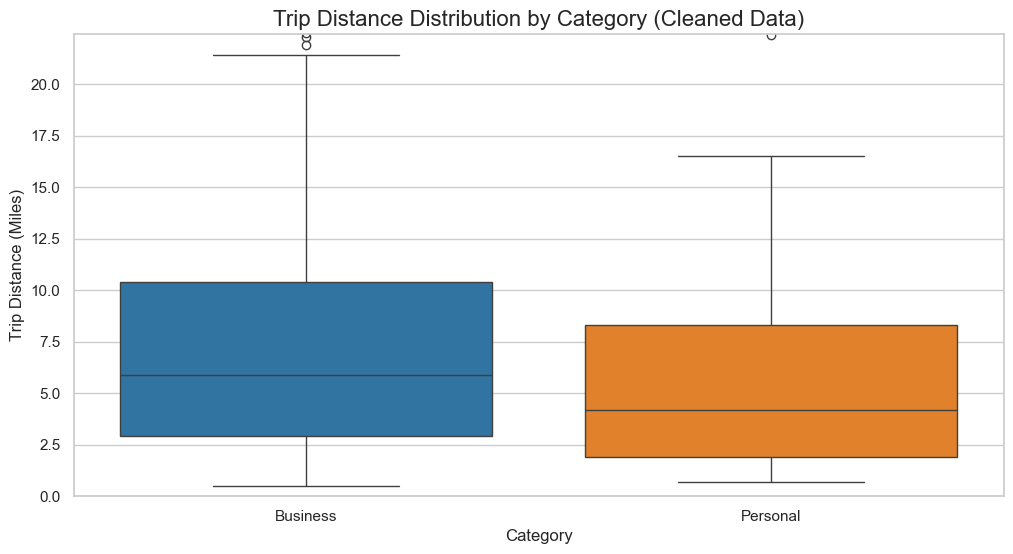

In [77]:
plt.figure(figsize=(12,6))
sns.boxplot(x='CATEGORY', y='MILES_cleaned', data=df, palette=['#1f77b4', '#ff7f0e'])
plt.title('Trip Distance Distribution by Category (Cleaned Data)', fontsize=16)
plt.ylabel('Trip Distance (Miles)')
plt.xlabel('Category')
plt.ylim(0, df['MILES_cleaned'].quantile(0.95))
plt.show()

In [78]:
distance_stats = df.groupby('CATEGORY')['MILES_cleaned'].agg(['mean', 'median', 'std', 'count']).reset_index()
print(distance_stats)

   CATEGORY      mean  median       std  count
0  Business  8.447866     5.9  9.857380   1078
1  Personal  7.057143     4.2  7.815781     77


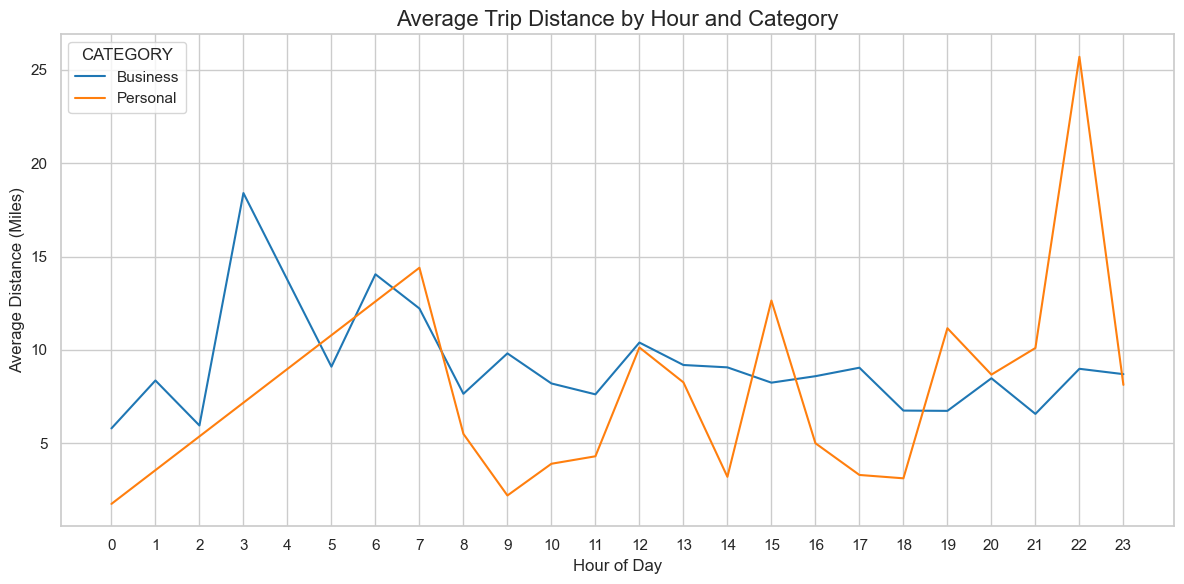

In [79]:
avg_dist_hour = df.groupby(['CATEGORY', 'hour'])['MILES_cleaned'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=avg_dist_hour, x='hour', y='MILES_cleaned', hue='CATEGORY', palette=['#1f77b4', '#ff7f0e'])
plt.title('Average Trip Distance by Hour and Category', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Average Distance (Miles)')
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

In [80]:
corr = df[['MILES_cleaned', 'duration_min']].corr().loc['MILES_cleaned', 'duration_min']
print(f"Pearson correlation between trip distance and duration: {corr:.3f}")

Pearson correlation between trip distance and duration: 0.472


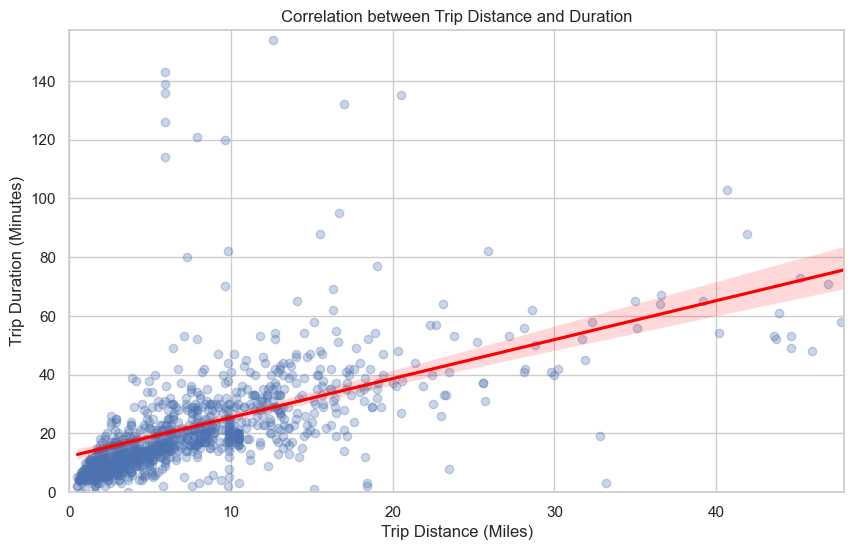

In [82]:
plt.figure(figsize=(10,6))
sns.regplot(x='MILES_cleaned', y='duration_min', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Correlation between Trip Distance and Duration')
plt.xlabel('Trip Distance (Miles)')
plt.ylabel('Trip Duration (Minutes)')
plt.xlim(0, df['MILES_cleaned'].quantile(0.99))  
plt.ylim(0, df['duration_min'].quantile(0.99))  
plt.show()

In [83]:
for cat in df['CATEGORY'].unique():
    subset = df[df['CATEGORY'] == cat]
    corr_cat = subset[['MILES_cleaned', 'duration_min']].corr().loc['MILES_cleaned', 'duration_min']
    print(f"Correlation for {cat}: {corr_cat:.3f}")

Correlation for Business: 0.467
Correlation for Personal: 0.562
Correlation for nan: nan


In [84]:
df.head(4)

START_DATE            END_DATE  CATEGORY        START         STOP  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce  Fort Pierce   

   MILES          PURPOSE  hour       day    month  duration_min day_type  \
0    5.1   Meal/Entertain  21.0    Friday  January           6.0  Weekday   
1    5.0              NaN   1.0  Saturday  January          12.0  Weekend   
2    4.8  Errand/Supplies  20.0  Saturday  January          13.0  Weekend   
3    4.7          Meeting  17.0   Tuesday  January          14.0  Weekday   

  dist_range    trip_day time_bucket  MILES_cleaned  
0       5–10  2016-01-01     Evening            5.1  
1       5–10  2016-01-02  Late Night            5.0  
2        1–5  2016-01-02     Evening            4.8  
3        1–5  2016-01-05   Afternoon            4.7

In [85]:
df['PURPOSE'].value_counts()

PURPOSE
Meeting            187
Meal/Entertain     160
Errand/Supplies    128
Customer Visit     101
Temporary Site      50
Between Offices     18
Moving               4
Airport/Travel       3
Charity ($)          1
Commute              1
Name: count, dtype: int64

In [86]:
purpose_counts = df['PURPOSE'].value_counts().reset_index()
purpose_counts.columns = ['Purpose', 'Count']
purpose_counts['Percentage'] = 100 * purpose_counts['Count'] / purpose_counts['Count'].sum()
print(purpose_counts)

           Purpose  Count  Percentage
0          Meeting    187   28.637060
1   Meal/Entertain    160   24.502297
2  Errand/Supplies    128   19.601838
3   Customer Visit    101   15.467075
4   Temporary Site     50    7.656968
5  Between Offices     18    2.756508
6           Moving      4    0.612557
7   Airport/Travel      3    0.459418
8      Charity ($)      1    0.153139
9          Commute      1    0.153139


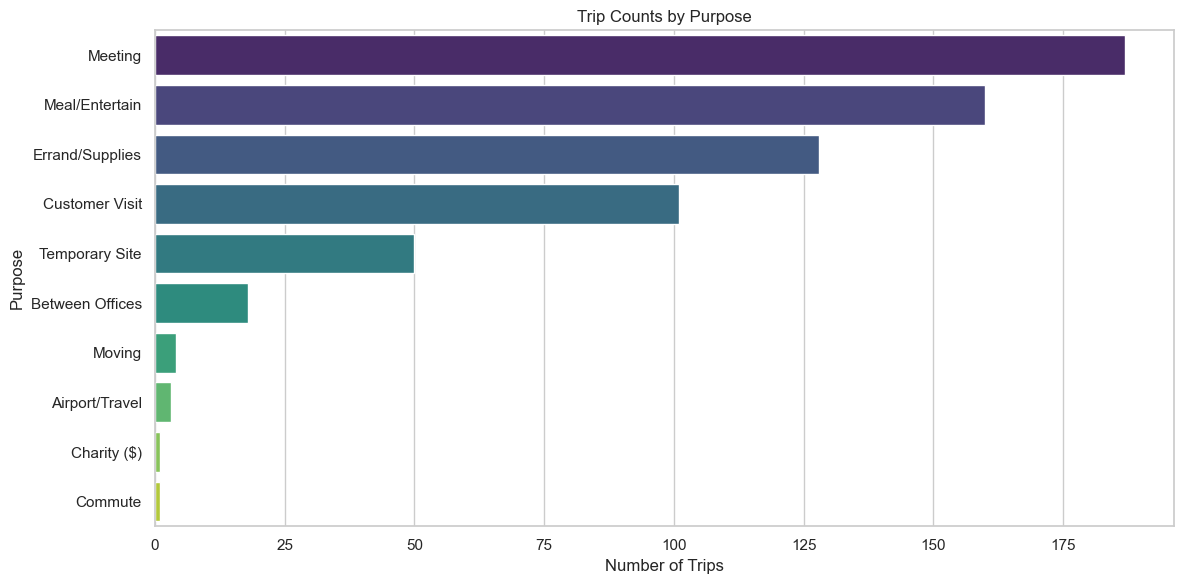

In [87]:
plt.figure(figsize=(12,6))
sns.barplot(x='Count', y='Purpose', data=purpose_counts, palette='viridis')
plt.title('Trip Counts by Purpose')
plt.xlabel('Number of Trips')
plt.ylabel('Purpose')
plt.tight_layout()
plt.show()

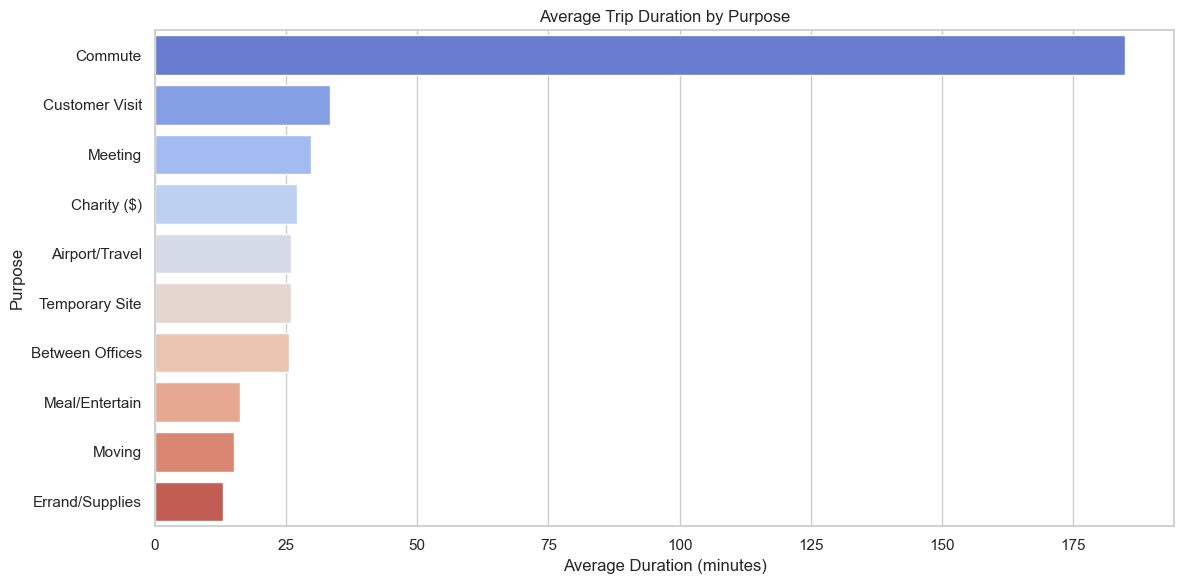

In [88]:
avg_duration_purpose = df.groupby('PURPOSE')['duration_min'].mean().reset_index().sort_values('duration_min', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='duration_min', y='PURPOSE', data=avg_duration_purpose, palette='coolwarm')
plt.title('Average Trip Duration by Purpose')
plt.xlabel('Average Duration (minutes)')
plt.ylabel('Purpose')
plt.tight_layout()
plt.show()

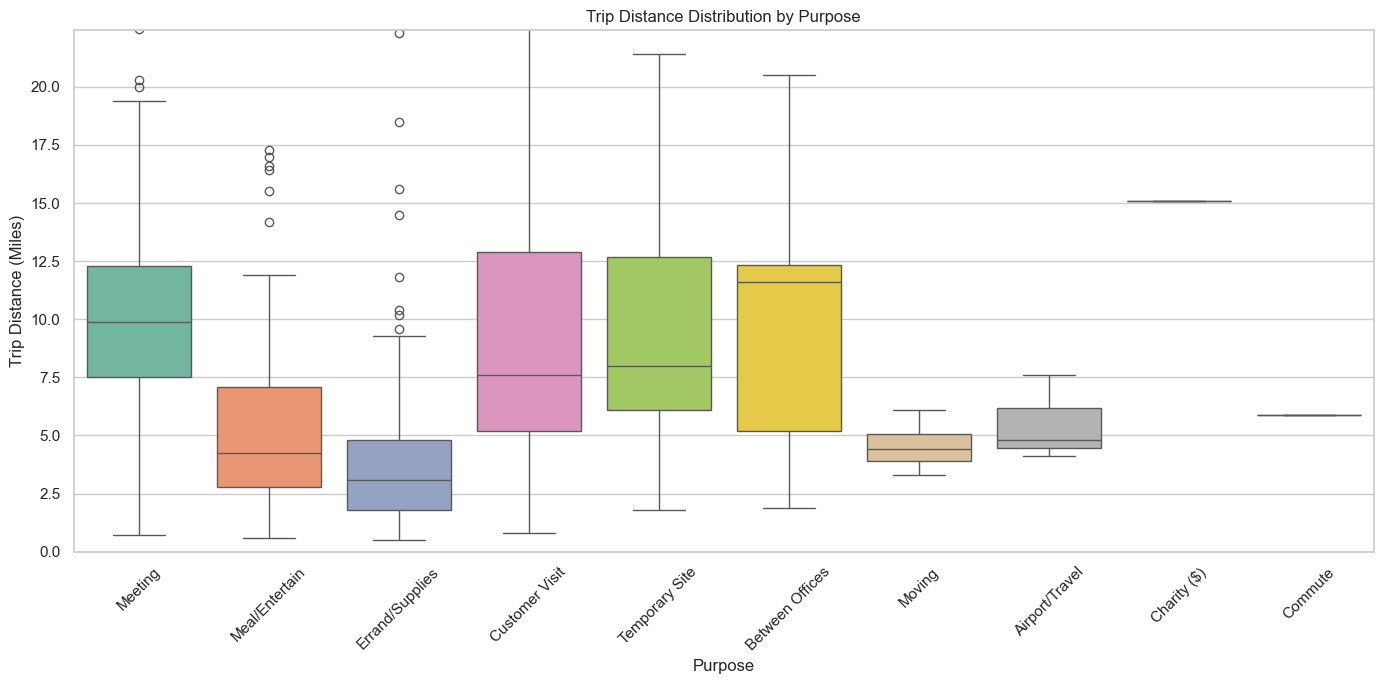

In [89]:
plt.figure(figsize=(14,7))
sns.boxplot(x='PURPOSE', y='MILES_cleaned', data=df, order=purpose_counts['Purpose'],
            palette='Set2')
plt.title('Trip Distance Distribution by Purpose')
plt.xlabel('Purpose')
plt.ylabel('Trip Distance (Miles)')
plt.xticks(rotation=45)
plt.ylim(0, df['MILES_cleaned'].quantile(0.95))  # Limit to 95th percentile
plt.tight_layout()
plt.show()

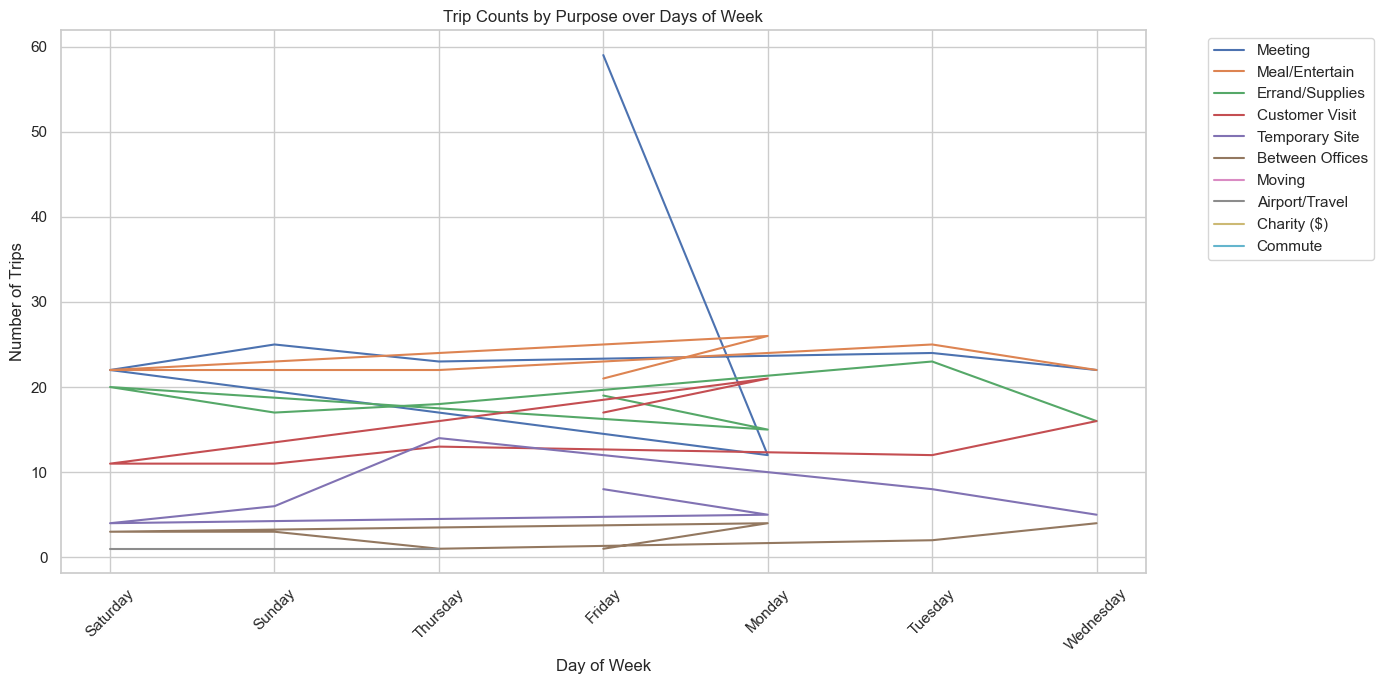

In [90]:
purpose_day = df.groupby(['PURPOSE', 'day']).size().reset_index(name='trip_count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14,7))
sns.lineplot(data=purpose_day, x='day', y='trip_count', hue='PURPOSE', 
             hue_order=purpose_counts['Purpose'], sort=False)
plt.title('Trip Counts by Purpose over Days of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()